# Synthesizing a Time-Series based Energy Dataset

The aim of this petite notebook is to generate
 time series data based on an input time-series data.

TimeGAN from YData's [ydata-synthetic](https://github.com/ydataai/ydata-synthetic) library is put to use
 to achieve this task.

* Input dataset source: https://github.com/jsyoon0823/TimeGAN/blob/master/data/energy_data.csv



## Issues

* TimeGAN seems to be working with version 0.3.0, but not with 0.4.0, the latest version.
    * Update: For v0.4.0, `gan_args` should be of following tpe:
        ```
        gan_args = ModelParameters(batch_size=batch_size,
                               lr=learning_rate,
                               noise_dim=noise_dim,
                               layers_dim=dim)
        ```
    * This change puts betas by default as `(None, None)` which
    is not empty, and so technically no parameter is missing from list.
* `samples_size=250` not to be used during scatter plot.

## 1. Import Libraries

In [1]:
import os
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_synthetic.synthesizers.timeseries import TimeGAN

## 2. Define Model Hyperparameters

In [2]:
# Specific to TimeGANs
seq_len=24
n_seq = 28
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = [batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim]


## 3. Read the Input data

In [3]:
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading

file_path = "./data/energy_data.csv"
stock_df = pd.read_csv(file_path)

try:
    stock_df = stock_df.set_index('Date').sort_index()
except:
    stock_df=stock_df

# Data transformations to be applied prior to be used with the synthesizer model
stock_data = real_data_loading(stock_df.values, seq_len=seq_len)

print(len(stock_data), stock_data[0].shape)

19711 (24, 28)


* We have 19711 instances of the input data
* Each instance has 28 features, and 24 timestamps
* A timeseries data is just another type of dataset,
with an extra parameter as time instance. And so for
every instance of time, we have another dataset with
different values.

## 4. Training the TimeGAN synthetizer

In [4]:
if path.exists('synth_energy.pkl'):
    synth = TimeGAN.load('synth_energy.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=500)
    synth.save('synth_energy.pkl')

## 5. Generating Synthetic Energy Data

In [5]:
synth_data = synth.sample(len(stock_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 154/154 [00:35<00:00,  4.34it/s]


(19712, 24, 28)


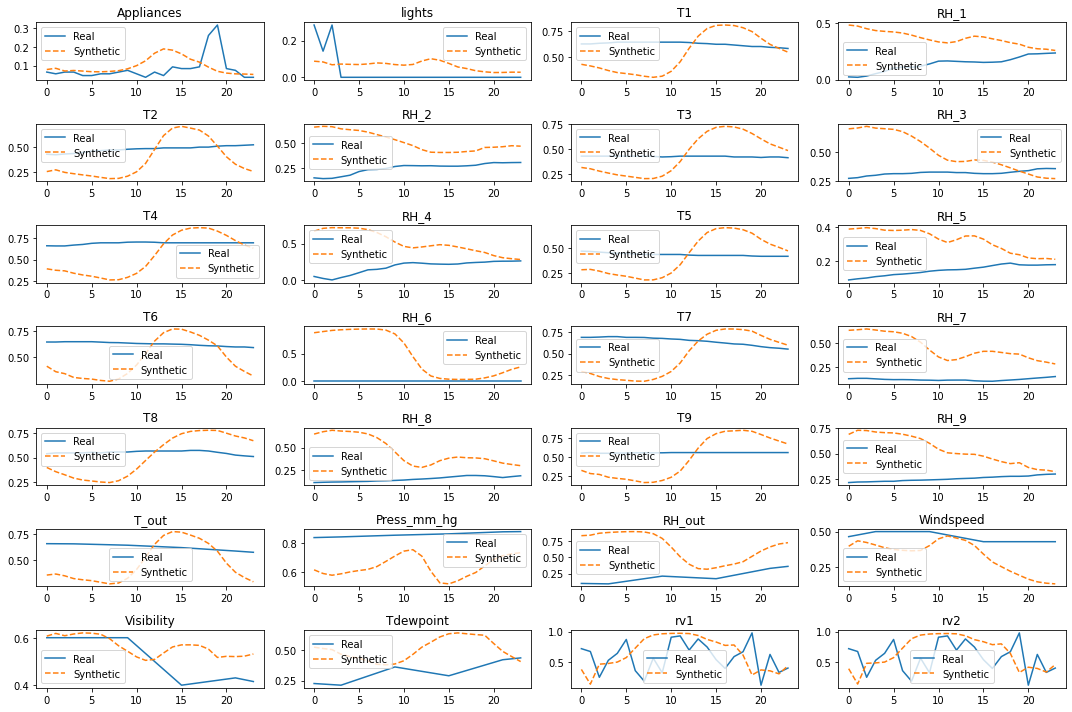

In [6]:
cols = ["Appliances", "lights", "T1", "RH_1", "T2", "RH_2",
        "T3", "RH_3","T4", "RH_4", "T5", "RH_5", "T6",
        "RH_6", "T7", "RH_7", "T8", "RH_8", "T9", "RH_9",
        "T_out", "Press_mm_hg", "RH_out", "Windspeed",
        "Visibility", "Tdewpoint", "rv1", "rv2"
]

# Plotting some generated samples. Both Synthetic and Original data are still standardized with values between [0, 1]
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/comparison_gan_outputs.png', dpi=200)

## 6. Evaluation of the generated synthetic data (PCA and TSNE)

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

# Convert list to array, but taking only 250 random samples
# stock_data: (list(19711(ndarray(24, 28)))) -> real_sample: ndarray(250, 24, 28)
real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

# For the purpose of comparison we need the data to be 2-Dimensional.
# For that reason we are going to use only two components for both the PCA and TSNE.
# synth_data_reduced: {ndarray: (7000, 24)}
# stock_data_reduced: {ndarray: (7000, 24)}
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

# The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

# pca_real: {DataFrame: (7000, 2)}
# pca_synth: {DataFrame: (7000, 2)}
pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

# data_reduced: {ndarray: (14000, 24)}
data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)

# tsne_results: {DataFrame: (14000, 2)}
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

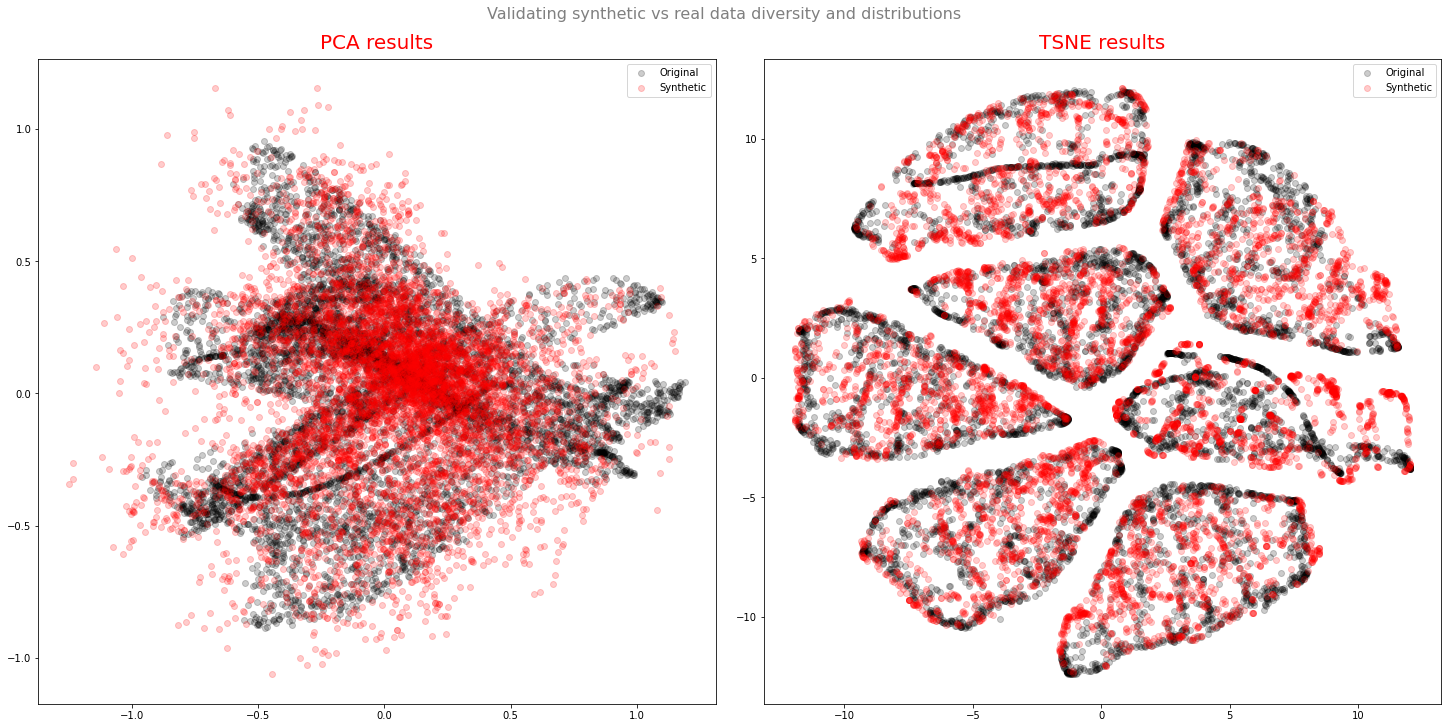

In [10]:
# Scatter plots for PCA and t-SNE methods

import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

# t-SNE scatter plot
plt.scatter(tsne_results.iloc[:7000, 0].values, tsne_results.iloc[:7000, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[7000:, 0], tsne_results.iloc[7000:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/synthetic_vs_real_data_diversity_and_distributions.png', dpi=200)